# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import random
import sys

sys.path.append('../..')
# Experiments
from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 0.5,
    'R1': 2,
    'R2': 2/3
}

def lrna_price(asset: str):
    return price_dict['LRNA'] / price_dict[asset]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 1000000, 'LRNA_price': lrna_price('USD')},
                'R1': {'liquidity': 1000000, 'LRNA_price': lrna_price('R1')},
                'R2': {'liquidity': 3000000, 'LRNA_price': lrna_price('R2')},
            },
            lrna_fee=0,
            asset_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'R1': 1000000, 'R2': 1000000},
            trade_strategy=random_swaps(pool_id='omnipool', amount={'R1': 500 * lrna_price('R1'), 'R2': 500 * lrna_price('R2')})
        ), 
        'LP1': Agent(
            holdings={'R1': 500000},
            trade_strategy=invest_all('omnipool')
        ), 
        'LP2': Agent(
            holdings={'R2': 1500000},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function = None,
    external_market = price_dict
)

events = run.run(initial_state, time_steps=5000)

Starting simulation...
Execution time: 1.437 seconds.


In [2]:
events = processing.postprocessing(events, optional_params=['pool_val', 'usd_price', 'impermanent_loss', ])

processing {'usd_price', 'deposit_val', 'withdraw_val', 'pool_val', 'impermanent_loss'}


In [3]:
%matplotlib inline

## Analysis

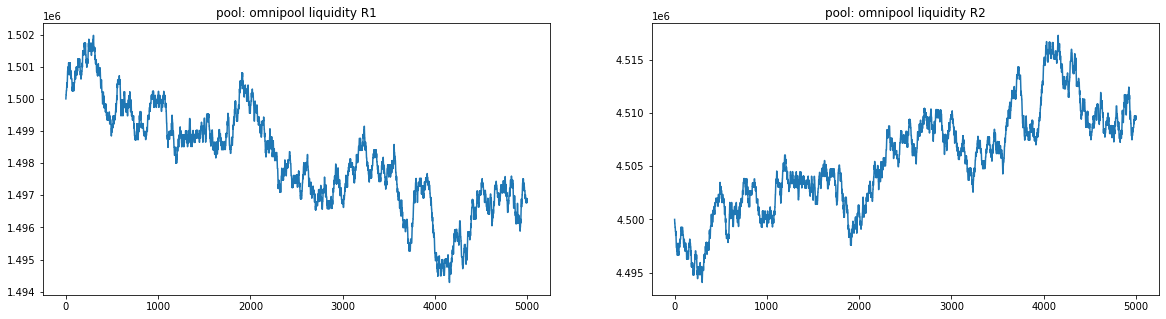

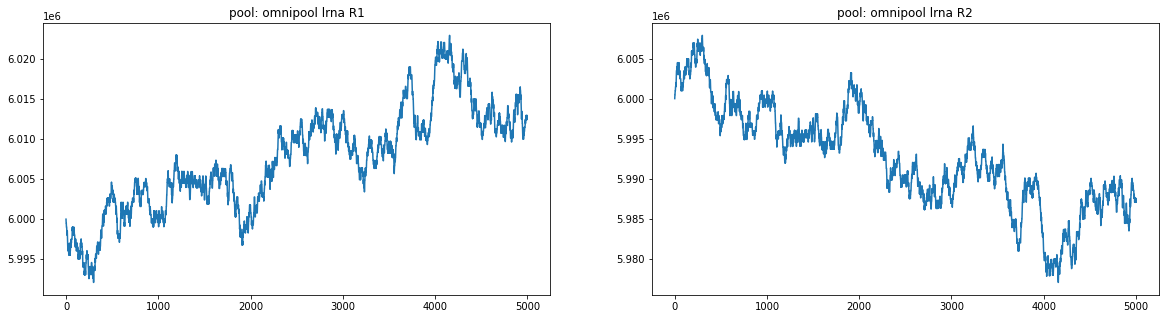

In [4]:
pu.plot(events, pool='omnipool', prop='liquidity', key=['R1', 'R2'])
pu.plot(events, pool='omnipool', prop='lrna', key=['R1', 'R2'])

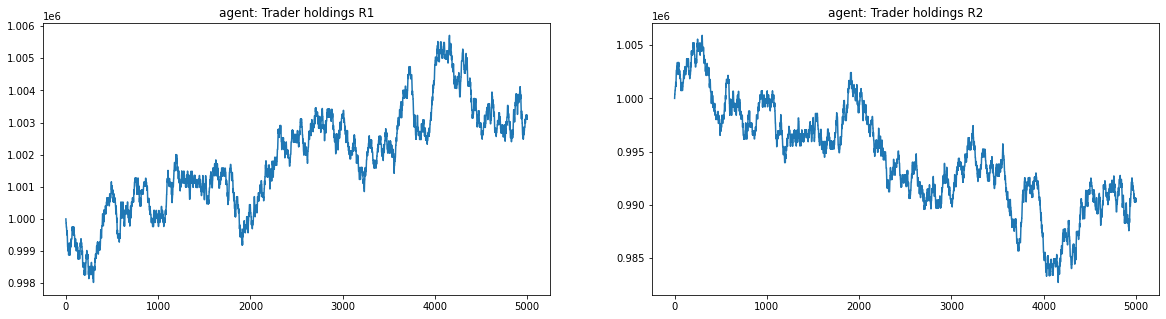

In [5]:
pu.plot(events, agent='Trader', prop='holdings')


## IL over time



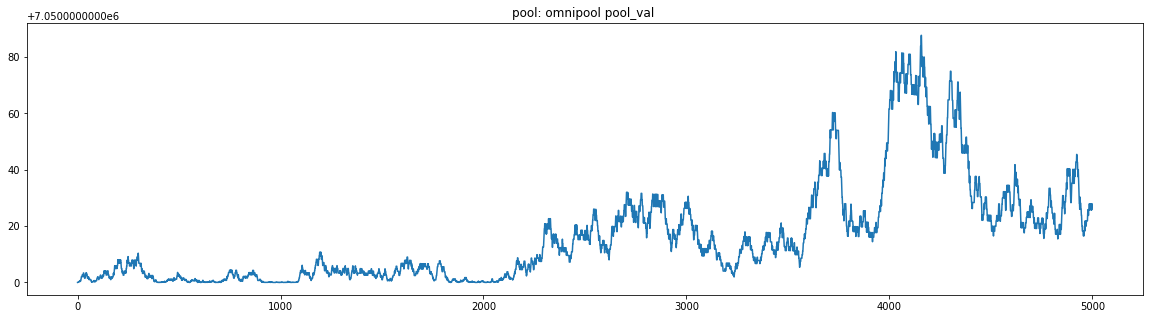

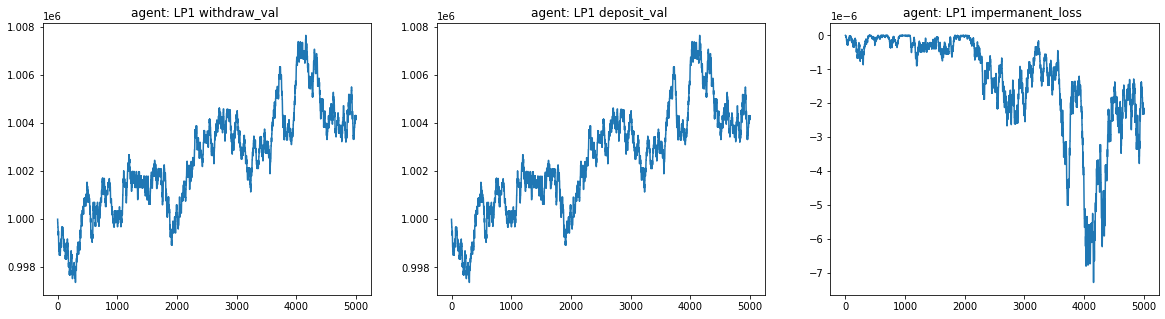

In [6]:
pu.plot(events, pool='omnipool', prop='pool_val')
pu.plot(events, agent='LP1', prop=['withdraw_val', 'deposit_val', 'impermanent_loss'])
# pu.plot(events, agent='LP1', prop='deposit_val')
# pu.plot(events, agent='LP1', prop='impermanent_loss')

## IL as a function of price movement

### Theory

On a price move from $p_i^Q \to k p_i^Q$, LP is entitled to $k\frac{\sqrt{k}}{k+1}$ of the *original value* of the matched pool.
$$
Val_{hold} = k p_i^Q R_i\\
Val_{pool} = k\frac{\sqrt{k}}{k+1} 2Q_i = \left(2k\frac{\sqrt{k}}{k+1}\right) p_i^Q R_i
$$

### $Val_{hold}$

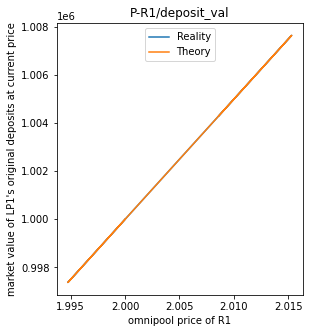

In [7]:
def val_hold_func(P, R):
    return P * R

plt.figure(figsize=(15,5))

ax = plt.subplot(131, title='P-R1/deposit_val')
x = pu.get_datastream(events, pool='omnipool', prop='usd_price', key='R1')
y = pu.get_datastream(events, agent='LP1', prop='deposit_val')
ax.set_xlabel('omnipool price of R1')
ax.set_ylabel("market value of LP1's original deposits at current price") 
ax.plot(x, y, label='Reality')

# ax = plt.subplot(132, title='P-R1/deposit_val')
x = pu.get_datastream(events, pool='omnipool', prop='usd_price', key='R1')
y = [val_hold_func(price, initial_state.agents['LP1'].holdings['R1']) for price in x]
ax.plot(x, y, label='Theory')
plt.legend(loc='upper center')

### $Val_{Pool}$

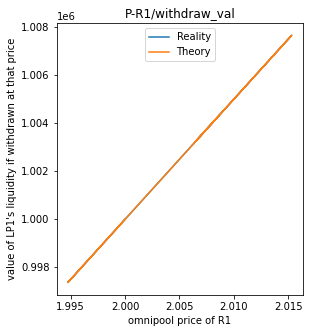

In [8]:
import math
def val_pool_func(P, P_init, R):
    k = P/P_init
    return 2 * k * math.sqrt(k) / (k + 1) * P_init * R

plt.figure(figsize=(15,5))

ax = plt.subplot(131, title='P-R1/withdraw_val')
x = pu.get_datastream(events, pool = 'omnipool', prop='usd_price', key='R1')
y = pu.get_datastream(events, agent = 'LP1', prop='withdraw_val')
ax.set_xlabel('omnipool price of R1')
ax.set_ylabel("value of LP1's liquidity if withdrawn at that price") 
ax.plot(x, y, label='Reality')

# ax = plt.subplot(132, title='P-R1/withdraw_val')
y = [val_pool_func(price, initial_state.price('R1'), initial_state.agents['LP1'].holdings['R1']) for price in x]
ax.plot(x, y, label='Theory')
plt.legend(loc='upper center')

### Impermanent Loss

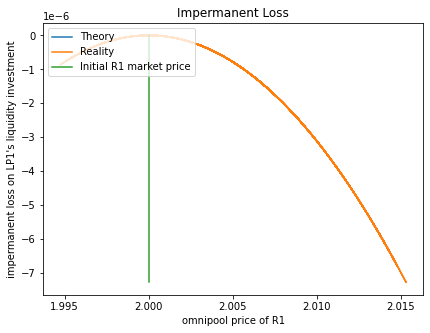

In [10]:
def IL_func(P, P_init, R):
    return val_pool_func(P, P_init, R)/val_hold_func(P, R) - 1

plt.figure(figsize=(15,5))


ax = plt.subplot(121, title='Impermanent Loss')
y = [IL_func(price, initial_state.price('R1'), initial_state.agents['LP1'].holdings['R1']) for price in x]
ax.set_xlabel('omnipool price of R1')
ax.set_ylabel("impermanent loss on LP1's liquidity investment") 
ax.plot(x, y, label='Theory')

# ax = plt.subplot(122, title='Actual')
x = pu.get_datastream(events, pool='omnipool', prop='usd_price', key='R1')
y = pu.get_datastream(events, agent='LP1', prop='impermanent_loss')
ax.plot(x, y, label='Reality')

x = [initial_state.external_market['R1']] * 2
y = [min(y), max(y)]
ax.plot(x, y, label='Initial R1 market price')
plt.legend(loc='upper left')